# Header

In [1]:
import os
import cv2
import glob
import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import numpy as np
import scipy as s
import scipy.signal as sig

In [2]:
# Check directory
os.chdir("D:\Raphael\Dropbox\Mcgill\JupyterNotebook\PHYS512")
os.getcwd()

'D:\\Raphael\\Dropbox\\Mcgill\\JupyterNotebook\\PHYS512'

# Functions

## Utility functions

In [3]:
# returnm some important and much used values of the histogram
def histo_imp_val(rho, edge):
    nx = len(rho[0]) # number of bins in x
    ny = len(rho[1])
    nz = len(rho[2])
    dx = edge[0][1]-edge[0][0] # size of bin in x
    dy = edge[1][1]-edge[1][0]
    dz = edge[2][1]-edge[2][0]
    minx = edge[0][0] #end of each axes
    miny = edge[1][0]
    minz = edge[2][0]
    return nx,ny,nz,dx,dy,dz,minx,miny,minz

In [4]:
# Define single ptcl softened potential (softened green's function)
def soft_pot(rho,edge,a):
    nx,ny,nz,dx,dy,dz,minx,miny,minz = histo_imp_val(rho, edge)
    pot = np.zeros(shape=(nx*2-1,ny*2-1,nz*2-1))
    for i in range(nx*2-1):
        for j in range(ny*2-1):
            for k in range(nz*2-1): # looking at some bin i,j,k
                x = (i+1)*dx+2*minx # position of the center of the bin in x, given ptcl at x=0.5 (i.e at the center, since x=[0,1) )
                y = (j+1)*dy+2*miny
                z = (k+1)*dz+2*minz
                r = np.sqrt(x**2+y**2+z**2+a**2) # distance btw center of bin and and particle
                pot[i,j,k] = -1/r
    return pot

In [5]:
# return the ijk coordinate of a (ONE) given cell position (x_n)
def x_to_ijk(x_n, rho, edge):
    nx,ny,nz,dx,dy,dz,minx,miny,minz = histo_imp_val(rho, edge)
    x = x_n[0]
    y = x_n[1]
    z = x_n[2]
    i = int(round((x-minx)/dx - 0.5))
    j = int(round((y-miny)/dy - 0.5))
    k = int(round((z-minz)/dz - 0.5))
    #print(i,j,k) #debugging
    return i,j,k

In [6]:
# return the ijk coordinate of a set of (MANY) cell position(x_n)
def xn_to_ijk(x_n, rho, edge):
    nx,ny,nz,dx,dy,dz,minx,miny,minz = histo_imp_val(rho, edge)
    x = np.transpose(np.transpose(x_n)[0])
    y = np.transpose(np.transpose(x_n)[1])
    z = np.transpose(np.transpose(x_n)[2])
    i = np.round((x-minx)/dx - 0.5)
    j = np.round((y-miny)/dy - 0.5)
    k = np.round((z-minz)/dz - 0.5)
    indices  = np.transpose(np.row_stack((i,j,k)))
    ijk = np.concatenate(indices.astype(int), axis=None)# change the ijk into int and puts them all in one axis
    index = np.linspace(0,3*len(x_n)-1,len(x_n)*3)# make a list of index for every element in ijk
    i_ijk = ijk[((index-0)%3)==0]
    j_ijk = ijk[((index-1)%3)==0]
    k_ijk = ijk[((index-2)%3)==0]
    return [i_ijk,j_ijk,k_ijk],indices # return the element in ijk which corresponf to a i, a j, or a k

In [7]:
# Order the elements in x_n in order of ascending x, then y, then z
def order_x(x,rho,edge):
    [i_ijk,j_ijk,k_ijk],indices = xn_to_ijk(x, rho, edge)
    return x[np.lexsort((np.transpose(indices)[2],np.transpose(indices)[1],np.transpose(indices)[0]))]

In [ ]:
# return the [x,y,z] of a cell i,j,k
# (I think I finally don't use it in the final code, but hey, just in case I gonna leave it here)
def ijk_to_x(i,j,k,rho,edge):
    nx,ny,nz,dx,dy,dz,minx,miny,minz = histo_imp_val(rho, edge)
    return np.array([[(i+0.5)*dx+minx,(j+0.5)*dy+miny,(k+0.5)*dz+minz]])

In [9]:
# second iteration of a funcion that computes the energy of the system
def Energy2(x,v,phi,rho,edge,m):
    [i,j,k],indices  = xn_to_ijk(x, rho, edge)
    K = 0.5*np.sum(m*v**2)
    P = 0.5*np.sum(phi[i,j,k])
    return K+P,K,P

In [10]:
# Delete all ptcl which is outside of the bound (-1,1)
def non_periodic(x,m,v):
    N = len(x)
    TF_upper_i = x > 1
    TF_lower_i = x < -1
    TF_upper = np.any(TF_upper_i, axis=1)
    TF_lower = np.any(TF_lower_i, axis=1)
    TF_i = np.row_stack((TF_upper,TF_lower))
    TF = np.any(TF_i, axis=0)
    x = np.delete(x,[i for i, val in enumerate(TF) if val],0)
    m = np.delete(m,[i for i, val in enumerate(TF) if val],0)
    v = np.delete(v,[i for i, val in enumerate(TF) if val],0)
    return x,m,v

In [26]:
# Define the k^-3 spectrum (part 4)
def k_spectrum(n):
    dx = 2/n
    pot = np.zeros(shape=(n,n,n))
    for i in range(n):
        for j in range(n):
            for k in range(n): # looking at some bin i,j,k
                x = (i+1)*dx-1
                y = (j+1)*dx-1
                z = (k+1)*dx-1
                k_freq = np.sqrt(x**2+y**2+z**2) 
                if k_freq==0: pot[i,j,k] =0.0
                else: pot[i,j,k] = 1/(np.abs(k_freq**3))
    return pot

In [30]:
# Allow to transform the rho nxnxn matrix to a nx3 matrix of all the points position,
# thus allowing us to plot it using plot_graph3D()
def rho_to_x(rho,edge):
    x = np.array([[0,0,0]])
    nx,ny,nz,dx,dy,dz,minx,miny,minz = histo_imp_val(rho, edge)
    for i in range(nx):
        #print("i=",i) #Debugging
        for j in range(ny):
            for k in range(nz):
                if rho[i,j,k] != 0.:
                    for nb_ptcl in range(int(rho[i,j,k])):
                        position = np.array([[(i+0.5)*dx+minx,(j+0.5)*dy+miny,(k+0.5)*dz+minz]])# obtain position
                        x = np.concatenate((x,position),axis=0)# add it to the list of points x
                    
    return x[1:] #removes the first dummy point [0,0,0] and return x

## Plot functions

In [11]:
# define function for easy visual check (thanks Marcus!)
def plot_2D_collapse(H,edges):
    edges_x = edges[0]
    edges_y = edges[1]
    edges_z = edges[2]
    fig,ax = plt.subplots(figsize=(5,5), dpi=100)
    im = ax.imshow(
        H.sum(axis=2),
        origin="lower",
        extent=(edges_x.min(), edges_x.max(), edges_y.min(), edges_y.max()), 
        aspect="auto")
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    minor_ticks_x = edges_x
    minor_ticks_y = edges_y
    ax.set(xlim=(minor_ticks_y[0], minor_ticks_y[-1]), ylim=(minor_ticks_x[0], minor_ticks_x[-1]))
    ax.set_xticks(minor_ticks_y, minor=True)
    ax.set_yticks(minor_ticks_x, minor=True)

    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
    plt.show

In [28]:
# Same as lot_2D_collapse2(), but for plotting the k^-3 
# spectrum in number 4 (I did not have time to make it work with the original function)
def plot_2D_collapse2(H,n):
    fig,ax = plt.subplots(figsize=(10,10), dpi=100)
    im = ax.imshow(
        H[n],
        origin="lower",
        extent=(-1, 1, -1, 1), 
        aspect="auto")
    ax.set_xlabel("y")
    ax.set_ylabel("x")

    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

In [12]:
#Return a 3D plot of the given x
def plot_graph3D(x, edge, title ="", scale_factor = 100,save=False, show = True, name = "fig",n = 0, view1=20,view2=60):
    #Create figure
    x = np.transpose(x)
    fig=plt.figure(figsize=(10,10))#Create 3D axes
    ax=Axes3D(fig) 
    ax.scatter(x[0], x[1], x[2], color="royalblue", marker=".",s=.02*scale_factor)
    ax.set_xlabel("x-coordinate",fontsize=14)
    ax.set_ylabel("y-coordinate",fontsize=14)
    ax.set_zlabel("z-coordinate",fontsize=14)
    ax.set_title(title,fontsize=20)
    #ax.legend(loc="upper left",fontsize=14)
    #ax.xaxis.set_ticklabels([])
    #ax.yaxis.set_ticklabels([])
    #ax.zaxis.set_ticklabels([])
    ax.set_xlim3d(edge[0].min(),edge[0].max())
    ax.set_ylim3d(edge[1].min(),edge[1].max())
    ax.set_zlim3d(edge[2].min(),edge[2].max())
    ax.view_init(view1,view2)
    plt.show
    if save:
        plt.savefig('Pictures_Final_Project/{}{}.png'.format(name,str(n).zfill(10)), dpi=100)
    if show  == False:
        plt.close(fig)

In [13]:
# plot a quiver plot ()
def quiver(rho,edge,phi,scale_factor=1):
    nx,ny,nz,dx,dy,dz,minx,miny,minz = histo_imp_val(rho, edge)
    X = np.linspace(-1+0.5*dx, 1-0.5*dx,nx)
    Y = np.linspace(-1+0.5*dy, 1-0.5*dy,ny)
    Fx = np.transpose(np.gradient(phi)[0])[int(size/2+1)]
    Fy = np.transpose(np.gradient(phi)[1])[int(size/2+1)]
    U, V = np.meshgrid(Y, X)
    
    fig, ax = plt.subplots(figsize=(10,10), dpi=100)
    q = ax.quiver(U,V, Fx*scale_factor, Fy*scale_factor)
    #ax.quiverkey(q, X=0.3, Y=1.1, U=10, labelpos='E')

    plt.show()

## Video functions

In [14]:
# Create a video from the picture in the output folder
def movie_from_image(title = 'project.avi',fps = 15):
    img_array = []
    for filename in glob.glob('{}\\*.png'.format(os.path.join(os.getcwd(), 'Pictures_Final_Project'))):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
 
    out = cv2.VideoWriter(title,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
 
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    
    print('Video finish')
    return 0

In [15]:
# empty the folder in which I store the picture so that the next simulation has a fresh and clean folder to work with
def empty_folder():
    files = glob.glob('Pictures_Final_Project\\*')
    for f in files:
        os.remove(f)

## Function doing the simulation

In [16]:
# Initialize the NxNxN matrix with the ptcl in it
# Create the density Matrix
# Order the ptcl such that they are in ascending order
# Create the Green's Function
# Compute Potential
def Initialize(x, m, size, a = 0.005, plot_2D = True, plot_3D = False, sc_factor = 10000):
    # Create density matrix rho
    print("Density rho :")
    rho,edge = np.histogramdd(x,bins=size,range=((-1,1),(-1,1),(-1,1)), weights = m)
    if plot_2D: plot_2D_collapse(rho,edge)
    print(" -- COMPLETE --")

    print("Order x :")
    # Order the x in order of ascending x, then y, then z
    x = order_x(x,rho, edge)
    print(" -- COMPLETE --")
    
    # Create softened potential matrix s_pot
    print("Green's Func :")
    greens_f = soft_pot(rho,edge,a)
    # Note : this plot goes from -2/2
    if plot_2D: plot_2D_collapse(greens_f,edge)
    print(" -- COMPLETE --")

    # Compute total potential matrix by convolving the density matrix with the softened potential
    # NOTE : the potential phi will be compute once again in Evolve(); this is only for visual check.
    print("Potential :")
    phi = sig.fftconvolve(rho,greens_f,mode='same')
    if plot_2D: plot_2D_collapse(phi,edge)
    print(" -- COMPLETE --")
    
    plot_graph3D(x,edge,scale_factor = sc_factor,save=False,show=plot_3D)
    
    return x, rho, edge, greens_f, phi

In [24]:
# evolve the system for nb_step time
def Evolve(dt, size, nb_step, x_n, m, rho_n, phi_n, rho, edge, greens_f, v_n0, 
           show_freq=1,sc_factor=100,plot_3D = True, plot_E = True, save_3D=False, 
           quiver_plot =True, print_info = False, bound = "periodic",
           name_file = "fig", view1=20,view2=60):
    
    [i,j,k],indices  = xn_to_ijk(x, rho, edge)
    acc_0 = -np.transpose(np.gradient(phi_n))
    m_matrix = m.reshape(len(x_n),1).repeat(3,1) # make a matrix out of m s.t. we can multiply it by acc
    #v_n = v_n0 + 0.5*m_matrix*acc_1*dt
    v_n = v_n0 + 0.5*acc_0[k,j,i]*dt
    
    # create a array to store the energy values
    E_values = np.zeros(shape=(nb_step+1,3))
    
    for nb in range(nb_step):
        if print_info:print("Step :",nb)#, end =" ") # print actual step
        
        
        # plot the ptcls in a 3D graph
        if nb%show_freq==0:# make an image if the step is a multiple of show_freq.
            plot_graph3D(x_n,edge,title = "Step {}".format(nb), 
                         scale_factor = sc_factor,save=save_3D, show = plot_3D, 
                         name = name_file,n = nb, view1=view1,view2=view2)
            if quiver_plot : quiver(rho_n,edge,phi_n,scale_factor=1)
        
            
        # Compute acceleration
        # NOTE : since I taking the transpose such that acc has dimension NxNxNx3, the indices are now (k,j,i,d).
        acc_n = -np.transpose(np.gradient(phi_n))
        
        # set an empty array for v_n1
        #v_n1 = v_n*0
        # set an empty array for x_n1
        #x_n1 = x*0         
        
        
        [i,j,k],indices = xn_to_ijk(x_n, rho, edge)# get the ptcl position in the matrix
        x_n1 = x_n + v_n*dt #update that said ptcl position
        #v_n1 = v_n + m_matrix*acc_n[k,j,i]*dt
        v_n1 = v_n + acc_n[k,j,i]*dt
        E = Energy2(x_n,v_n,phi_n,rho_n,edge,m_matrix)
        if bound == "periodic" : x_n1 = (x_n1-1)%2-1 #Assures that the ptcl is inside the boundaries of the box (-1,1)
        if bound == "n_periodic" : 
            x_n1,m,v_n1 = non_periodic(x_n1,m,v_n1)
            if len(x_n) == 0: 
                x_n1 = np.zeros(shape=(1,3))
                m = np.zeros(3)
                v_n1 = np.zeros(shape=(1,3))
            m_matrix = m.reshape(len(x_n1),1).repeat(3,1)
        if print_info:
            print(acc_n[k,j,i])
            print(v_n, end =" ")
            print(v_n1, end =" ")
            print("E=",E[0],"  K=",E[1],"  P=",E[2])

        # Create density matrix rho for step n1
        rho_n1,edge = np.histogramdd(x_n1,bins=size,range=((-1,1),(-1,1),(-1,1)), weights = m)
    
        # print the energy beside the the step number, and record its value in E_values
        #print("E=",E[0],"  K=",E[1],"  P=",E[2])
        E_values[nb] = E
    
        # plot the next step ptcls in a 3D graph iff we are in the last step
        if nb == nb_step-1:
            phi_n1 = sig.fftconvolve(rho_n1,greens_f,mode='same')
            print("Step :",nb+1, end =" ")
            E = Energy2(x_n,v_n,phi_n,rho_n,edge,m_matrix)
            #E = np.zeros(3)
            #for ptcl in range(len(x_n)):
            #    E = E + Energy(x_n[ptcl],v_n,phi_n,rho_n,edge)
            #print("E=",E[0],"  K=",E[1],"  P=",E[2])
            E_values[nb+1] = E
            plot_graph3D(x_n,edge,title = "Step {}".format(nb), 
                         scale_factor = sc_factor,save=save_3D, show = plot_3D, 
                         name = name_file,n = nb+1, view1=view1,view2=view2)
    
        # UPDATE THE VARIABLE FROM STEP n TO n+1 --------------------------------
        x_n = x_n1
        rho_n = rho_n1
        v_n = v_n1
        
        # Compute total potential matrix by convolving the density matrix with the softened potential
        phi_n = sig.fftconvolve(rho_n,greens_f,mode='same')
    
    # plot the energy
    if plot_E:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
        ax1.plot(np.linspace(0,nb_step,nb_step+1),np.transpose(E_values)[0],"bo-", label="E")
        ax2.plot(np.linspace(0,nb_step,nb_step+1),np.transpose(E_values)[1],"ro-", label="K")
        ax3.plot(np.linspace(0,nb_step,nb_step+1),np.transpose(E_values)[2],"go-", label="P")
        fig.legend()
        plt.show()
    
    return E_values

# === === === CODE === === ===

# Problem 1:
Using this code, show that a single particle starting at rest
remains motionless.

Density rho :
 -- COMPLETE --
Order x :
 -- COMPLETE --
Green's Func :
 -- COMPLETE --
Potential :
 -- COMPLETE --
Step : 100 

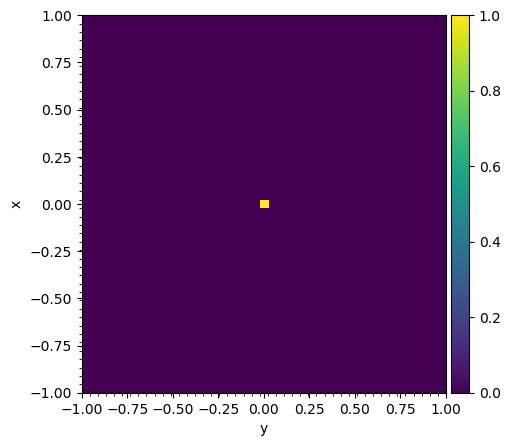

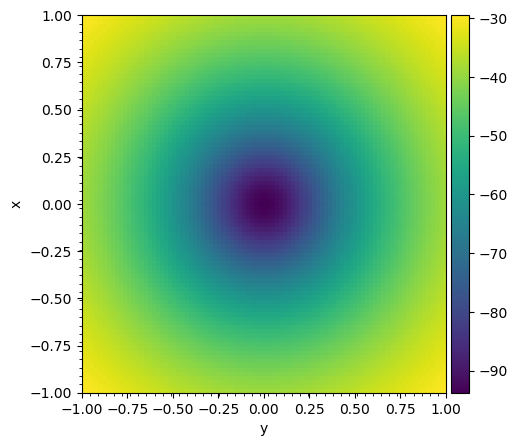

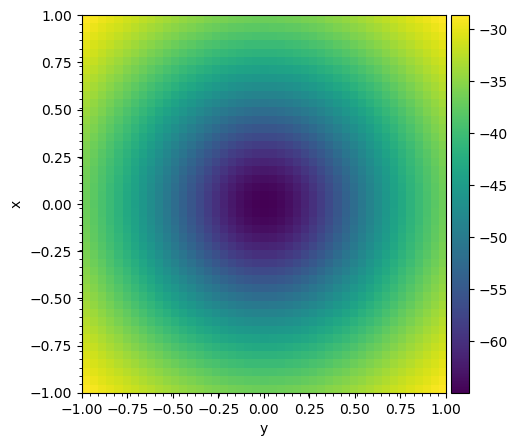

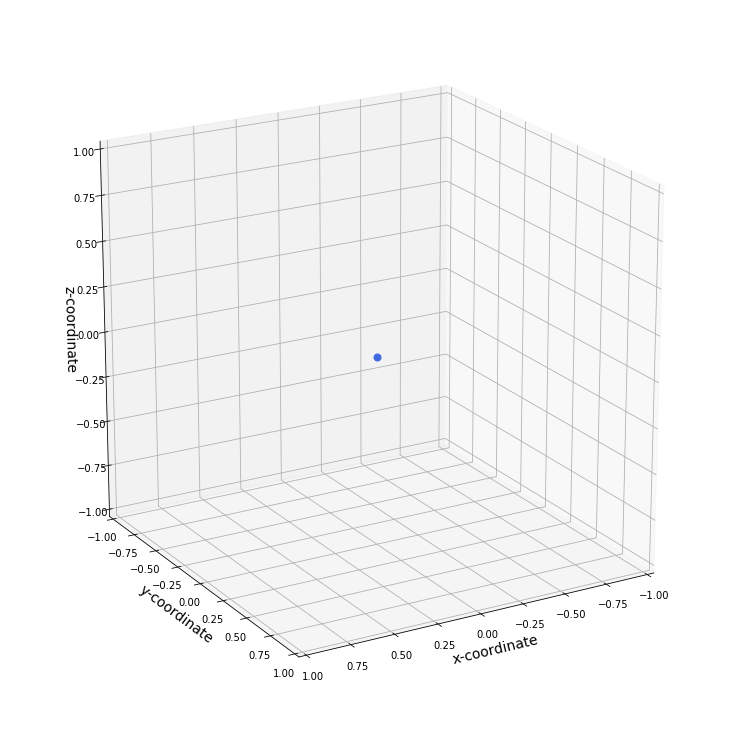

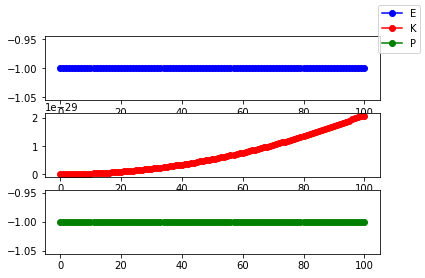

Time =  5.0
Video finish


In [18]:
# set inital parameters
size = 45
dt = 0.05
nb_step = 100
soft = 0.5
sc_fact = 10000

# one Ptcl in the center
x=np.array([[0.0,0.0,0.0]]) 
v_0=x*0
m = np.array([1.0])

# Initilise the system
x, rho, edge, greens_f, phi = Initialize(x, m, size,a=soft,plot_2D=True, plot_3D=True,sc_factor = sc_fact)
# Evolve the ptcl in time
Evolve(dt, size, nb_step, x, m, rho, phi, rho, edge, greens_f, v_0, 
       show_freq=1,sc_factor=sc_fact,plot_3D = False, save_3D=True, plot_E = True,
       quiver_plot = False, name_file = "fig", view1=90, view2=90)  

print ("Time = ",dt*nb_step)

movie_from_image(title = 'problem1.avi',fps = 8)

empty_folder()

In the video (Problem1.avi), the ptcl does not move. Also, one can see that the kinetic energy is the order of e-29. In other words, it is completly negligeable. Thus, the ptcl does stays motionless.

# Problem 2:
Next, show that a pair of particles placed in a circular orbit
continue to orbit each other, for at least some reasonable length of time.

Density rho :
 -- COMPLETE --
Order x :
 -- COMPLETE --
Green's Func :
 -- COMPLETE --
Potential :
 -- COMPLETE --
Step : 500 Time =  25.0
Video finish


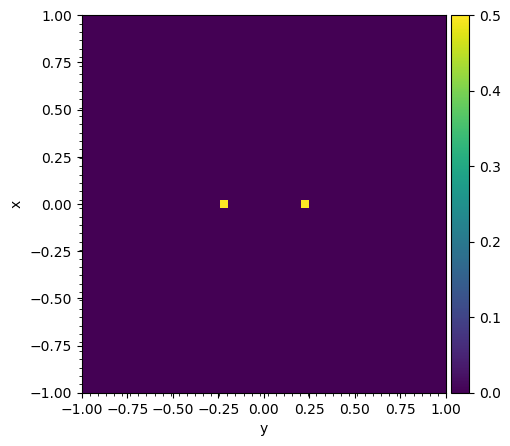

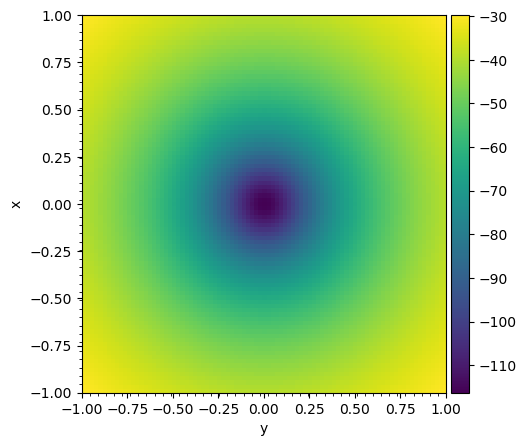

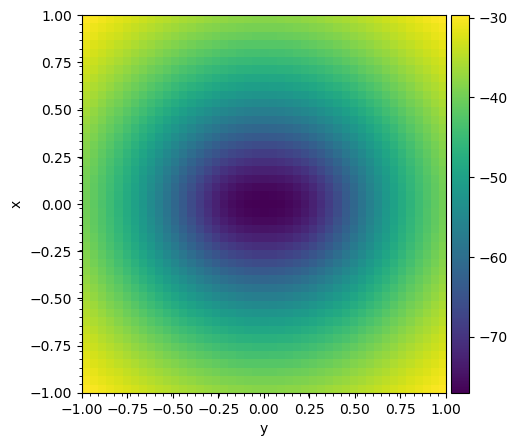

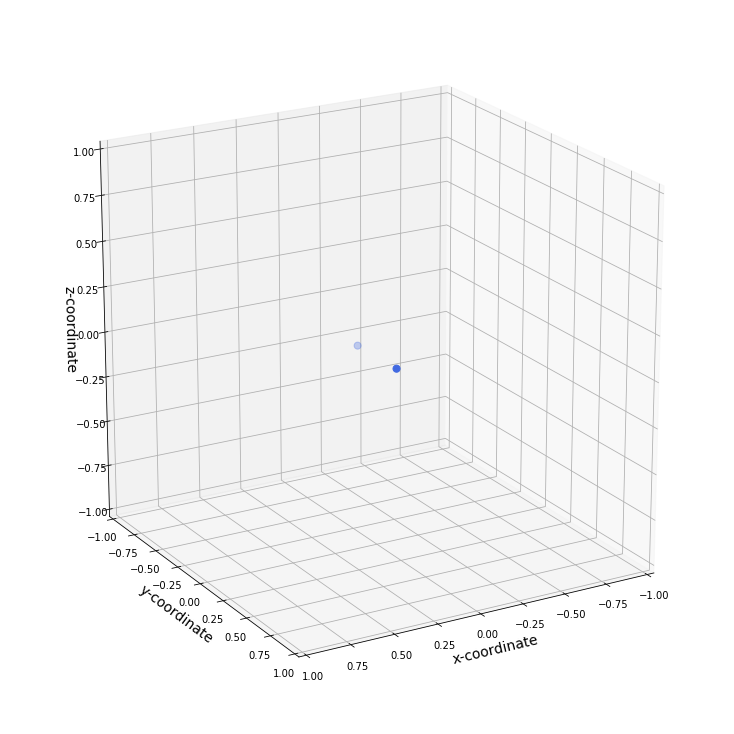

In [19]:
# set inital parameters
size = 45
dt = 0.05
nb_step = 500
soft = 0.3
sc_fact = 10000

# set up initial values x,v,m
speed = 0.12
mass = 0.5
distance = 0.2
x=np.array([[0.0,-distance,0.0],[0.0,distance,0.0]])
v_0=np.array([[-speed,0.0,0.0],[speed,0.0,0.0]])
m=np.array([mass,mass])

# Initilise the system
x, rho, edge, greens_f, phi = Initialize(x, m, size,a=soft,plot_2D=True, plot_3D=True,sc_factor = sc_fact)

E_values = Evolve(dt, size, nb_step, x, m, rho, phi, rho, edge, greens_f, v_0, 
       show_freq=1,sc_factor=sc_fact,plot_3D = False, save_3D=True, 
       print_info =False,quiver_plot = False,plot_E =False,
       name_file = "fig", view1=90, view2=90,bound = "periodic") 

print ("Time = ",dt*nb_step)

movie_from_image(title = 'problem2.avi',fps = 8)

empty_folder()

Looking at the video (problem2.avi), we see that the ptcls did indeed stayed in orbit with each other.

# Problem 3:
Set up both periodic and non-periodic boundary conditions. Set
up a problem where hundreds of thousands of particles are initially scattered
randomly throughout the domain. Show the evolution with time for both
periodic and non-periodic boundary conditions. Track the total energy -
how well is it conserved?

Density rho :
 -- COMPLETE --
Order x :
 -- COMPLETE --
Green's Func :
 -- COMPLETE --
Potential :
 -- COMPLETE --
Step : 500 

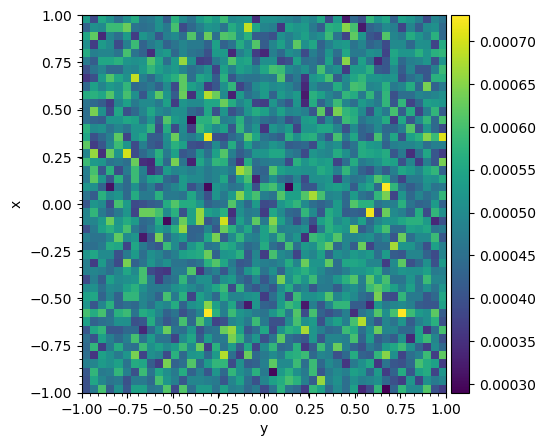

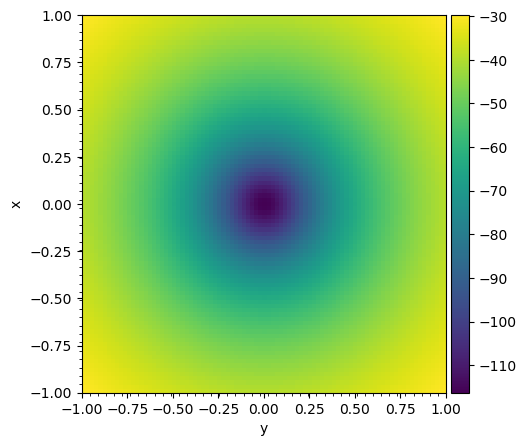

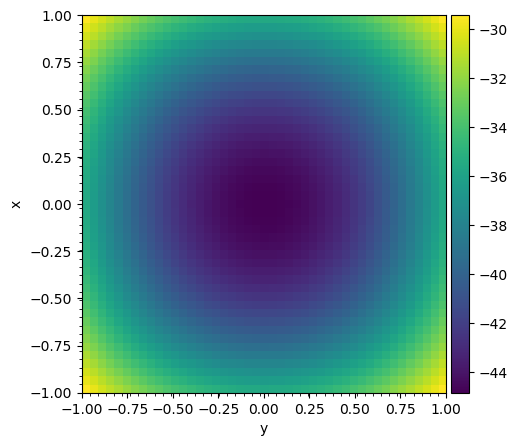

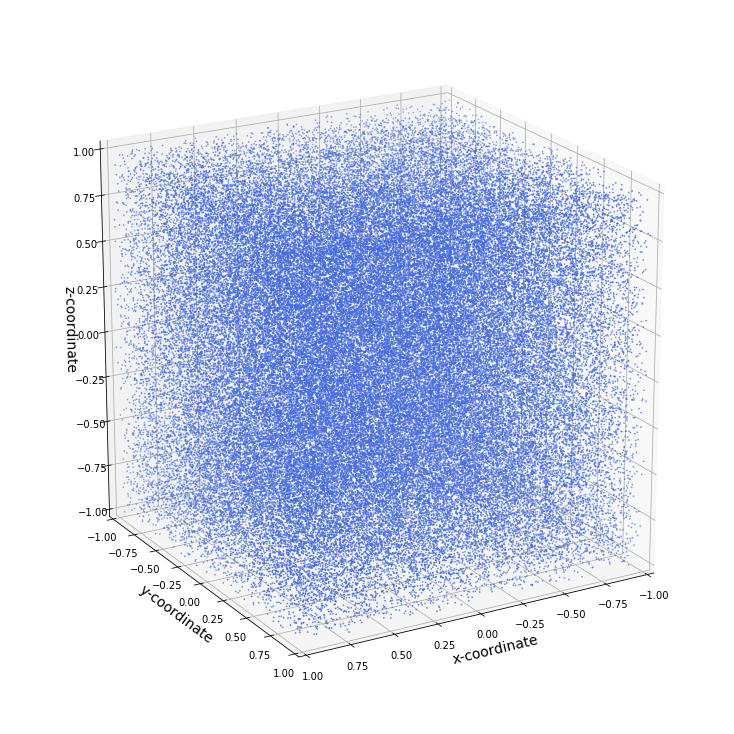

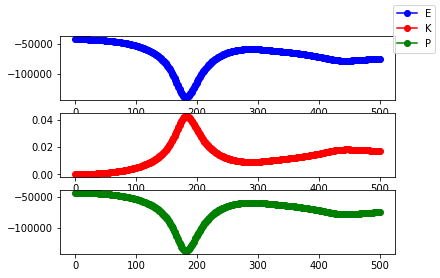

Time =  25.0
Video finish


In [20]:
# set inital parameters
N = 100000
size = 45
dt = 0.05
nb_step = 500
soft = 0.3
sc_fact = 100

# set up initial values x,v,m
x=np.random.rand(N,3)*2-1
v_0=x*0
m = np.ones(len(x))/N

# Initilise the system
x, rho, edge, greens_f, phi = Initialize(x, m, size,a=soft,plot_2D=True, plot_3D=True,sc_factor = sc_fact)

E_values = Evolve(dt, size, nb_step, x, m, rho, phi, rho, edge, greens_f, v_0, 
       show_freq=1,sc_factor=sc_fact,plot_3D = False, save_3D=True, 
       print_info =False,quiver_plot = False,plot_E =True,
       name_file = "fig", view1=20, view2=60,bound = "periodic") 

print ("Time = ",dt*nb_step)

movie_from_image(title = 'problem3_period.avi',fps = 8)

empty_folder()

One can see here that, up to a scaling factor for the potential, the energy is mostly conserved (aka the potential is the reflection of the Kinetic, thus summing to a constant).

Density rho :
 -- COMPLETE --
Order x :
 -- COMPLETE --
Green's Func :
 -- COMPLETE --
Potential :
 -- COMPLETE --
Step : 500 

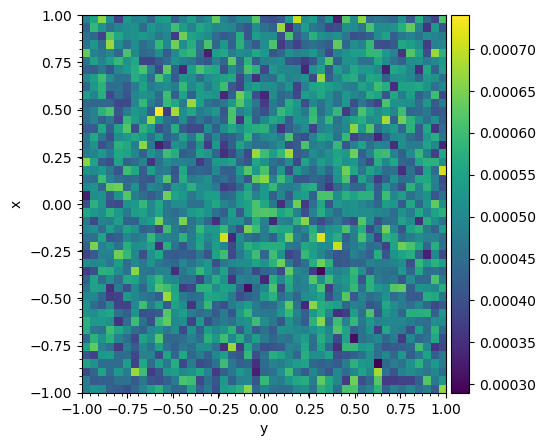

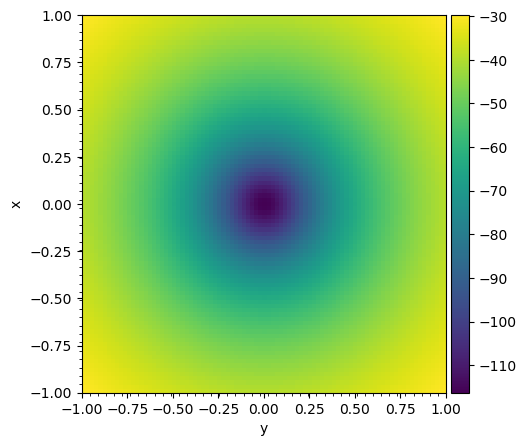

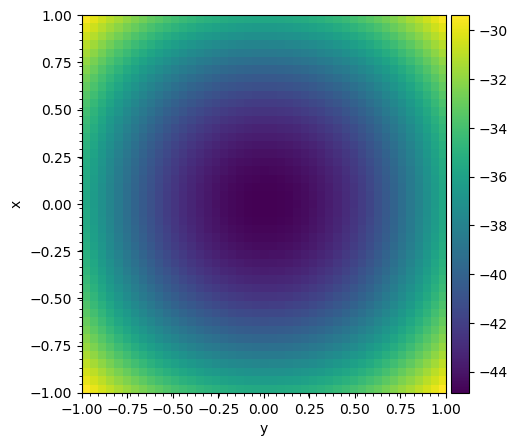

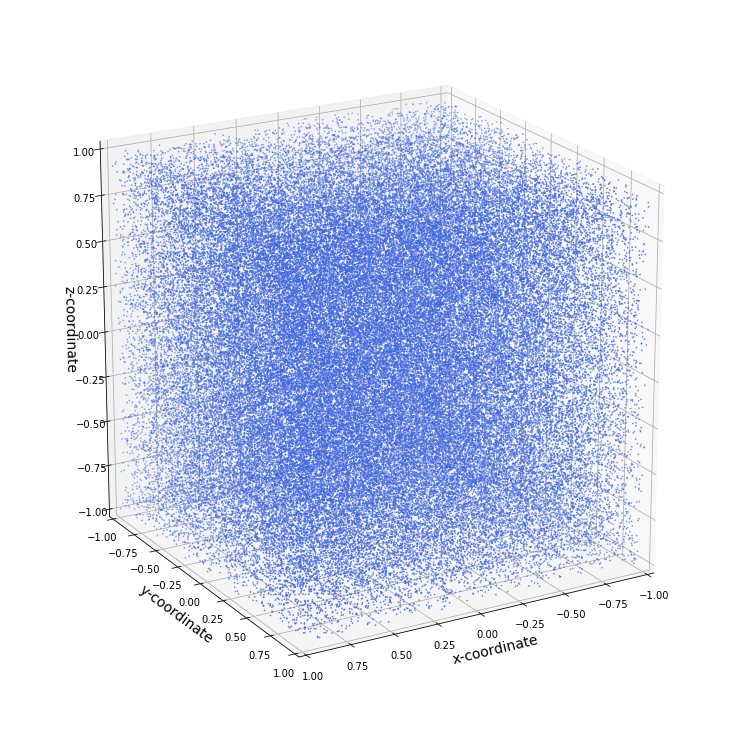

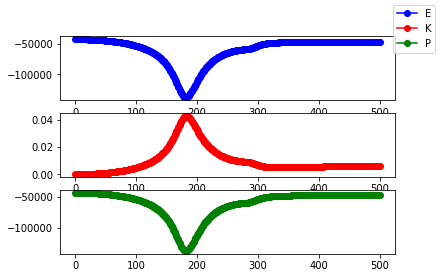

Time =  25.0
Video finish


In [25]:
# set inital parameters
N = 100000
size = 45
dt = 0.05
nb_step = 500
soft = 0.3
sc_fact = 100

# set up initial values x,v,m
x=np.random.rand(N,3)*2-1
v_0=x*0
m = np.ones(len(x))/N

# Initilise the system
x, rho, edge, greens_f, phi = Initialize(x, m, size,a=soft,plot_2D=True, plot_3D=True,sc_factor = sc_fact)

E_values = Evolve(dt, size, nb_step, x, m, rho, phi, rho, edge, greens_f, v_0, 
       show_freq=1,sc_factor=sc_fact,plot_3D = False, save_3D=True, 
       print_info =False,quiver_plot = False,plot_E =True,
       name_file = "fig", view1=20, view2=60,bound = "n_periodic") 

print ("Time = ",dt*nb_step)

movie_from_image(title = 'problem3_nperiod_2.avi',fps = 8)

empty_folder()

One can see here that, up to a scaling factor for the potential, the energy is mostly conserved (aka the potential is the reflection of the Kinetic, thus summing to a constant). Compared to the periodic boundary condition, the system seems to, when ptcl are destroyed (around the 300rd iteration), simply lose kinetic energy (positive) and kinetic energy (negative), resulting in no net change in the total energy.

# Part 4:
In cosmology, we start the universe with a scale-invariant power
spectrum, so mass fluctuations are proportional to $k^{−3}$
. Start with the particles on a grid, but with masses derived from a realization of $k^{−3}$ and use
periodic boundary conditions (although not strictly necessary, you may with
to start with your particles in the center of grid cells rather than at the
corners). How does your universe look now?

Initial N =  100000 // Final N =  99978.0
Density rho :
 -- COMPLETE --
Order x :
 -- COMPLETE --
Green's Func :
 -- COMPLETE --
Potential :
 -- COMPLETE --
Step : 500 

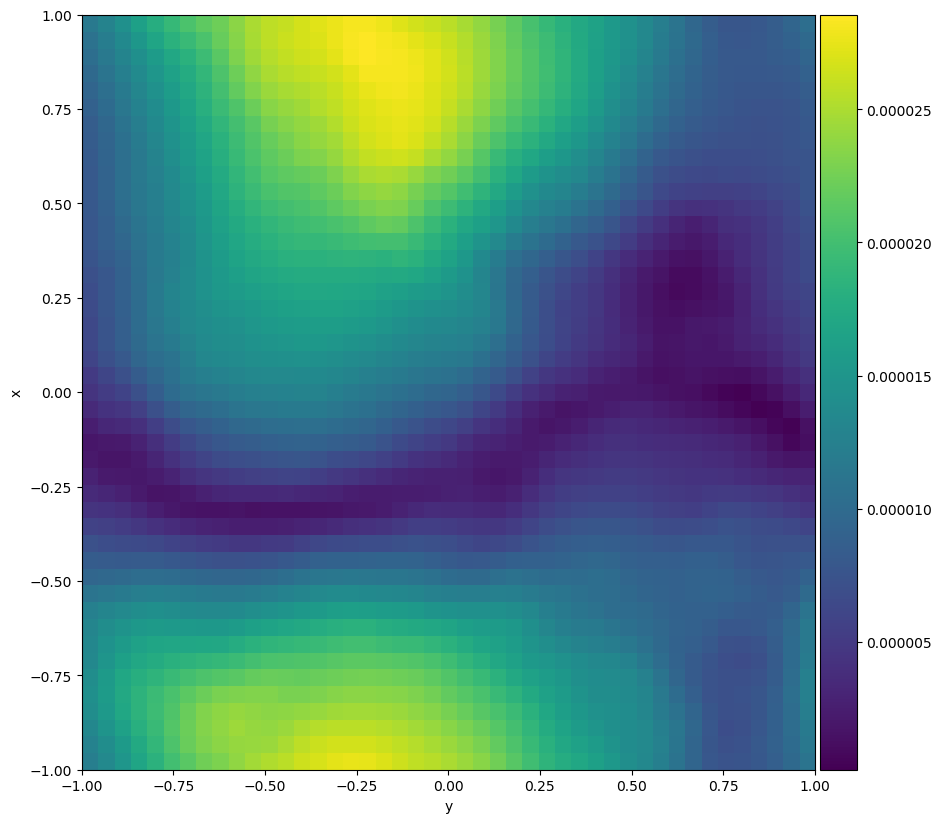

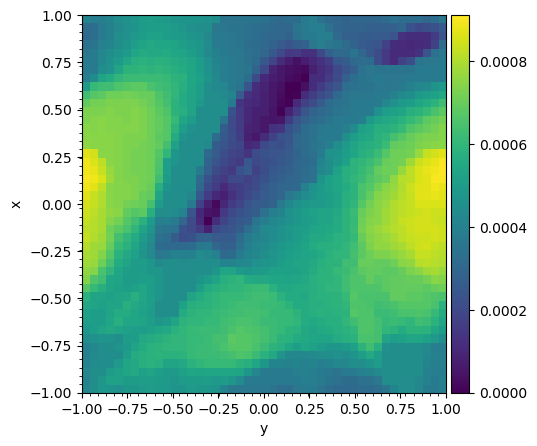

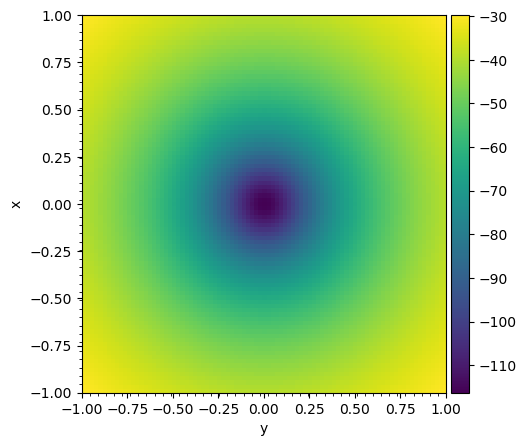

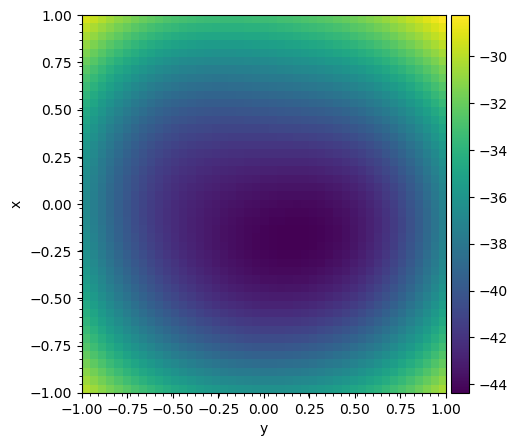

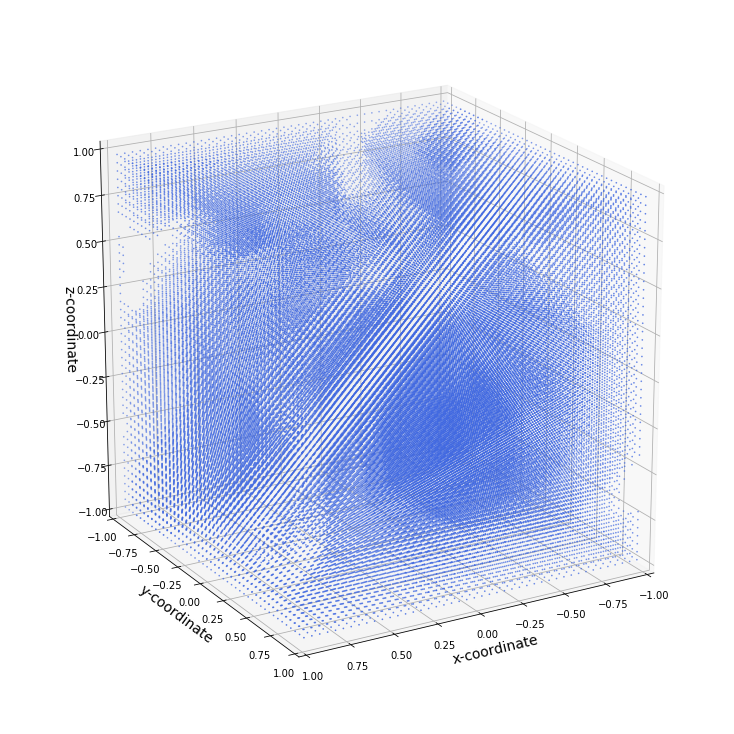

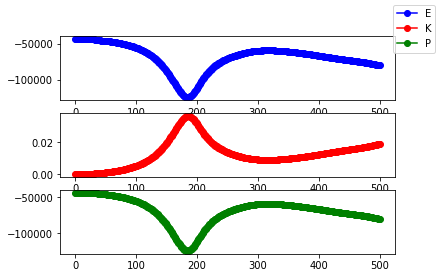

Time =  25.0
Video finish


In [32]:
# set inital parameters
N = 100000
size = 45
dt = 0.05
nb_step = 500
soft = 0.3
sc_fact = 100

# Generating the mass fluctuation
k3_density = np.fft.fftshift(np.roll(abs(np.fft.ifftn(k_spectrum(size)*np.fft.fftn(np.random.randn(size,size,size)))),1, (-1,1)))
k3_density = k3_density/np.sum(k3_density) # Normalizing
plot_2D_collapse2(k3_density,23) # plot it (slice 23)

# creating a usable rho from the k3_density with approx. N ptcls inside.
rho = np.zeros(shape=(size,size,size))
k3_density_new = k3_density*N
for i in range(size):
    for j in range(size):
        for k in range(size):
            rho[i,j,k] = round(k3_density_new[i,j,k])
print("Initial N = ",N,"// Final N = ",np.sum(rho))

x = rho_to_x(rho,edge)# creates a list of ptcl at the center of their respective cell
v_0=x*0
m = np.ones(len(x))/N

# Initilise the system
x, rho, edge, greens_f, phi = Initialize(x, m, size,a=soft,plot_2D=True, plot_3D=True,sc_factor = sc_fact)

E_values = Evolve(dt, size, nb_step, x, m, rho, phi, rho, edge, greens_f, v_0, 
       show_freq=1,sc_factor=sc_fact,plot_3D = False, save_3D=True, 
       print_info =False,quiver_plot = False,plot_E =True,
       name_file = "fig", view1=20, view2=60,bound = "periodic") 

print ("Time = ",dt*nb_step)

movie_from_image(title = 'Problem4.avi',fps = 8)

empty_folder()

In my simulation (video : problem4.avi), I was able to get the ptcl to have periodic boundary condition, but not to have a force which is periodic. Thus, has we can see here, the ptcls does not collapse in cluster has expected, but more into a "giant bubble" like the random particles in part 3. However, it is much less symmetric than part 3, thus we can expect that, after a large amount of time, the ptcls would at some point collapse into cluster.